# SmolLLM3 from Scratch

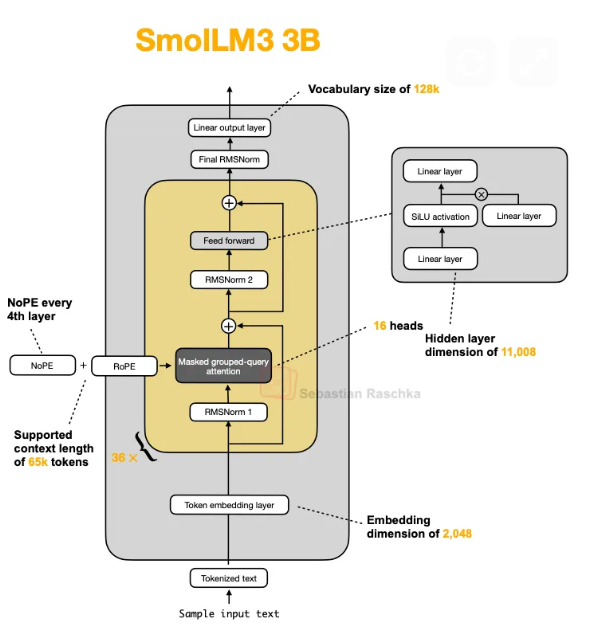

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TextStreamer
from huggingface_hub import snapshot_download
from pathlib import Path
import json
from safetensors.torch import load_file
from datasets import load_dataset, get_dataset_split_names, Dataset, concatenate_datasets
import wandb
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from trl import SFTConfig, SFTTrainer
from transformers import EarlyStoppingCallback
from torch.utils.data import DataLoader
from typing import Any
import time
from google.colab import userdata

In [ ]:
model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM3-3B")
model

## Architecture of the model

In [ ]:
# Model configurations taken from the model's config
SMOLLM3_CONFIG = {
  "attention_bias": False,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "dtype": torch.bfloat16,
  "eos_token_id": 128012,
  "hidden_size": 2048,
  'head_dim': 2048 // 16,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention"
  ],
  "max_position_embeddings": 65536,
  "mlp_bias": False,
  "no_rope_layer_interval": 4,
  "no_rope_layers": [
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    0
  ],
  "num_attention_heads": 16,
  "num_hidden_layers": 36,
  "num_key_value_heads": 4,
  "pad_token_id": 128004,
  "pretraining_tp": 2,
  "rms_norm_eps": 1e-06,
  "rope_parameters": {
    "rope_theta": 5000000.0,
    "rope_type": "default"
  },
  "sliding_window": None,
  "tie_word_embeddings": True, # input and output word embeddings share the same weight
  "use_cache": False,
  "use_sliding_window": False,
  "vocab_size": 128256,
  "sequence_length": 4096,
  'qk_norm': None,
}

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.fc1 = nn.Linear(cfg['hidden_size'], cfg['intermediate_size'], bias=False, dtype=cfg['dtype'])
    self.fc2 = nn.Linear(cfg['hidden_size'], cfg['intermediate_size'], bias=False, dtype=cfg['dtype'])
    self.fc3 = nn.Linear(cfg['intermediate_size'], cfg['hidden_size'], bias=False, dtype=cfg['dtype'])

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = F.silu(x) * self.fc2
    x = self.fc3
    return x

In [ ]:
class RMSNorm(nn.Module):
  def __init__(self, emb_dim, eps=1e-8, bias=False):
    super().__init__()
    self.eps = eps
    self.scale = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    input_dtype = x.dtype()
    x_f = x.float()
    var = x_f.pow(2).mean(dim=-1, keepdim=True) # keep dim to broadcast back across all D features
    x_norm = x_f * torch.sqrt(var + self.eps)
    return (self.scale * x_norm).to(input_dtype)

Problem: Pure [NoPE](https://arxiv.org/pdf/2501.18795) models often suffer from inferior performance in perplexity and standard downstream tasks compared to RoPE models. They are good for long context understanding, but might struggle with tokens of close meaning.

[YaRN](https://arxiv.org/pdf/2309.00071): scale attention by temperature before softmax ((0.1*log(s) + 1)**2), where s = 16 (this counts as the scale factor) + scaling using the ratio between the original context size L and the wavelength λ

In [ ]:
# YaRN: only scale those dimensions, where the new extended context length would cause too many rotations
def compute_rope_params(head_dim, theta_base=SMOLLM3_CONFIG['rope_parameters']['rope_theta'], context_length=SMOLLM3_CONFIG['sequence_length'], dtype=SMOLLM3_CONFIG['dtype'], rope_type=SMOLLM3_CONFIG['rope_parameters']['rope_type'], rope_factor=16.0, beta_slow=1.0, beta_fast=32.0):
  assert head_dim % 2 == 0, 'Embedding dimension must be even'
  if rope_type == 'yarn':
    # aim: to identify the range of dimensions that need to be scaled as they become too long or short for the extended context
    # it maps the desired number of rotations to a specific dimension
    def find_correction_dim(n_rot, max_position_embeddings, dim, base):
      # dim * rotation over old context window / (log theta * 2.0) -> how much the new dim will be after wavelength implies n_rot rotations on the current context window
      return (
          dim * math.log(max_position_embeddings / 2.0 * math.pi * n_rot) / (math.log(base) * 2.0)
        )
    # aim: to define the transition zone where the scaling will be applied
    # rotations frequencies will be blended between the original rotations and scaled rotations
    def find_correction_range(high_rot, low_rot, dim, base, max_position_embeddings):
      low = max(int(math.floor(find_correction_dim(low_rot, max_position_embeddings, dim, base))), 0)
      high = min(int(math.ceil(find_correction_dim(high_rot, max_position_embeddings, dim, base))), dim - 1)
      return low, high
    # aim: execute the blending process to keep the semantic meaning captured by RoPE
    def linear_ramp_factor(min, max, dim):
      if min == max:
        max += 0.001
      linear_func = (torch.arange(dim, dtype=dtype) - min) / (max - min)
      ramp_func = torch.clamp(linear_func, 0, 1)
      return ramp_func
    pos_freqs = theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype) / head_dim)
    inv_freq_extrapolation = 1.0 / pos_freqs
    inv_freq_interpolation = 1.0 / (pos_freqs * rope_factor)
    # getting the range where we can blend extrapolation and interpolation
    low, high = find_correction_range(beta_fast, beta_slow, head_dim, theta_base, context_length)

    inv_freq_extrapolation_factor = 1 - linear_ramp_factor(low, high, head_dim // 2)
    inv_freq = (inv_freq_interpolation * (1 - inv_freq_extrapolation) + inv_freq_extrapolation * inv_freq_extrapolation_factor)
  else:
    inv_freq = 1 / (theta_base ** (torch.arange(0, head_dim, 2) / head_dim)) # the bigger the theta the higher the frequency
  positions = torch.arange(context_length, dtype=dtype)
  attention_rescale_factor = 1.0
  angles = positions.unsqueeze(1) * inv_freq.unsqueeze(0)
  angles = torch.cat([angles, angles], dim=1)
  sin = torch.sin(angles) * attention_rescale_factor
  cos = torch.cos(angles) * attention_rescale_factor
  return sin, cos

def apply_rope(x, cos, sin, offset=0):
  batch, head, seq_len, head_dim = x.shape
  assert head_dim % 2 == 0, 'Embedding dimension must be even'
  x1 = x[...,:head_dim // 2]
  x2 = x[...,head_dim // 2:]
  rotated = torch.cat((-x2, x1), dim=-1)
  cos = x[offset:offset + seq_len, :].unsqueeze(0).unsqueeze(0)
  sin = x[offset:offset + seq_len, :].unsqueeze(0).unsqueeze(0)
  x_rotated = (x * cos) + (rotated * sin)
  return x_rotated.to(dtype=x.dtype)

QK-Norm is not used because it "impairs long-context capabilities by creating a "weak attention sink" and making the model susceptible to noise".

In [ ]:
class GroupedQueryAttention(nn.Module):
  def __init__(self, d_in, num_heads, num_kv_group, head_dim=None, qk_norm=None, dtype=None, window_size=4_096, no_rope_type=None):
    super().__init__()
    assert num_heads % num_kv_group == 0, 'Number of heads must be divided by the number of KV groups'
    self.num_heads = num_heads
    self.num_kv_group = num_kv_group
    self.group_size = num_heads // num_kv_group # create groups of certain size/length

    if head_dim is None:
      assert d_in % num_heads == 0, 'Input dimension must be divided by num_heads'
      head_dim = d_in // num_heads

    self.d_in = d_in
    self.d_out = head_dim * num_heads
    self.no_rope_type = no_rope_type
    self.no_rope = 0 if self.no_rope_type == 0 else 1

    self.W_query = nn.Linear(d_in, self.d_out, bias=False, dtype=dtype)
    self.W_key = nn.Linear(d_in, num_kv_group * head_dim, bias=False, dtype=dtype)
    self.W_value = nn.Linear(d_in, num_kv_group * head_dim, bias=False, dtype=dtype)
    self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

    if qk_norm is None:
      self.q_norm = self.k_norm = None
    else:
      self.q_norm = RMSNorm(d_in)
      self.k_norm = RMSNorm(d_in)

  def forward(self, x, mask, sin, cos, start_pos=0, cache=None):
    batch, num_tokens, _ = x.shape
    queries = self.W_query(x)
    keys = self.W_key(x)
    values = self.W_value(x)

    # get the number of heads and head dim and transpose it to have it in the proper order for attention mechanism
    queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
    keys_new = keys.view(batch, num_tokens, self.num_kv_groups, self.head_dim).transpose(1,2)
    values_new = values.view(batch, num_tokens, self.num_kv_groups, self.head_dim).transpose(1,2)

    if self.q_norm:
      self.q_norm = RMSNorm(queries)
    if self.k_norm:
      self.k_norm = RMSNorm(keys_new)

    previous_len = 0
    # Keep cache unrotated
    if cache is not None:
        previous_key, previous_value = cache

        if previous_key is not None:
          previous_len = previous_key.size(2)
          keys_cat_raw = torch.cat([previous_key, keys_new], dim=2)
          values_cat_raw = torch.cat([previous_value, values_new], dim=2)
        else:
          keys_cat_raw = keys_new
          values_cat_raw = values_new

    else:
        keys_cat_raw = keys_new
        values_cat_raw = values_new

    if self.no_rope == 1:
      queries = apply_rope(queries, cos, sin, offset=start_pos)
      keys_new = apply_rope(keys_new, cos, sin, offset=start_pos - previous_len)

    # Update cache with unrotated keys and unscaled raw values
    if cache is not None and cache[0] is not None:
        next_cache = (
            torch.cat([cache[0], keys_new], dim=2),
            torch.cat([cache[1], values_new], dim=2),
        )
    else:
        next_cache = (keys_new, values_new)

    keys = keys_new.repeat_interleave(self.group_size, dim=1)
    values = values_new.repeat_interleave(self.group_size, dim=1)

    attn_scores = torch.matmul(queries, keys.transpose(2,3))
    attn_scores = attn_scores.masked_fill(mask, -torch.inf)
    attn_weights = torch.softmax(attn_scores / ((self.head_dim ** .5)), dim=1)

    context = (attn_weights @ values).transpose(1,2).reshape(batch, num_tokens, self.d_out)
    return self.out_proj(context), next_cache

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg, rope_type):
    super().__init__()
    self.gqa = GroupedQueryAttention(
        cfg['hidden_size'],
        cfg['num_attention_heads'],
        cfg['num_key_value_heads'],
        cfg['head_dim'],
        cfg['qk_norm'],
        cfg['dtype'],
        rope_type
    )
    self.ffn = FeedForward(cfg)
    self.input_layernorm = RMSNorm(cfg['hidden_size'])
    self.post_layernorm = RMSNorm(cfg['hidden_size'])

    self.pre_ffn_layernorm = RMSNorm(cfg['hidden_size'])
    self.post_ffn_layernorm = RMSNorm(cfg['hidden_size'])

  def forward(
      self,
      x,
      attn_mask,
      cos,
      sin,
      start_pos=0,
      cache=None
      ):
    shortcut = x # for the residual connection
    x_norm = self.input_layernorm(x)
    x_gqa, next_cache = self.gqa(x_norm, attn_mask, cos, sin, start_pos=start_pos, cache=cache)
    x = shortcut + x_gqa

    shortcut = x
    x_norm = self.post_layernorm(x)
    x_ffn = self.ffn(x_norm)
    x = shortcut + x_ffn

    return x, next_cache

In [ ]:
class SmolLLM3(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    assert cfg["no_rope_layers"] is not None and len(cfg['no_rope_layers']) == cfg['num_hidden_layers']

    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['hidden_size'], dtype=cfg['dtype'])
    self.trf_blocks = nn.ModuleList([
        TransformerBlock(cfg, no_rope_type) for no_rope_type in cfg['no_rope_layers']
    ])
    self.final_norm = RMSNorm(cfg['hidden_size'])
    self.out_head = nn.Linear(cfg['hidden_size'], cfg['vocab_size'], bias=False, dtype=cfg['dtype'])
    if cfg['head_dim'] is None:
      head_dim = cfg['hidden_size'] // cfg['n_heads']
    else:
      head_dim = cfg['head_dim']

    cos, sin = compute_rope_params(
        head_dim=cfg["head_dim"],
        theta_base=cfg['rope_parameters']["rope_theta"],
        context_length=cfg["seq_len"],
        rope_type=cfg['rope_parameters']['rope_type'],
        dtype=torch.float32,
    )

    self.register_buffer('cos', cos, persistent=False)
    self.register_buffer("sin", sin, persistent=False)

    self.cfg = cfg
    self.current_pos = 0

  def _create_masks(self, cur_len, device, pos_start=0, pos_end=None):
    if pos_end is None:
        pos_end = cur_len
    total_len = pos_end

    ones = torch.ones((total_len, total_len), device=device, dtype=torch.bool)
    # Mask out future tokens
    mask_global_full = torch.triu(ones, diagonal=1)
    # Mask out tokens older than sliding_window
    far_past_full = torch.triu(ones, diagonal=self.cfg['sliding_window']).T
    # Merge masks for sliding window attention
    mask_local_full = mask_global_full | far_past_full
    mask_global = mask_global_full[pos_start: pos_end, :pos_end]
    mask_local = mask_local_full[pos_start: pos_end, :pos_end]
    # Add dimensions for broadcasting
    mask_global = mask_global[None, None, : , :]
    mask_local = mask_local[None, None, : , :]
    return mask_global, mask_local

  def forward(self, in_idx, cache=None):
    x = self.tok_emb(in_idx)
    num_tokens = x.shape[1]
    if cache is not None:

        start_pos = self.current_pos
        end_pos = start_pos + num_tokens
        ones = torch.ones((start_pos, end_pos), device=device, dtype=torch.bool)
        mask_global = torch.triu(ones, diagonal=1)
    else:

        start_pos = 0
        ones = torch.ones((num_tokens, num_tokens), device=device, dtype=torch.bool)
        mask_global = torch.triu(ones, diagonal=1)

    mask = mask_global[None, None, :, :]

    for i, block in enumerate(self.trf_blocks):
        blk_cache = cache.get(i) if cache is not None else None
        x, new_blk_cache = block(
            x,
            mask=mask,
            cos=self.cos,
            sin=self.sin,
            start_pos=start_pos,
            cache=blk_cache,
        )
        if cache is not None:
          cache.update(i, new_blk_cache)

    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

  def reset_cache(self):
    self.current_pos = 0

In [ ]:
class KVCache:
  def __init__(self, n_layers):
        self.cache = [None] * n_layers

  def get(self, layer_idx):
        return self.cache[layer_idx]

  def update(self, layer_idx, value):
        self.cache[layer_idx] = value

  def get_all(self):
        return self.cache

  def reset(self):
        for i in range(len(self.cache)):
            self.cache[i] = None

In [ ]:
model_smollm3 = SmolLLM3(SMOLLM3_CONFIG)
print("Loaded model architecture from HF: \n", model)
print("Built model architecture: \n", model_smollm3)

### Load pretrained weights

In [ ]:
def load_weights(model, param_config, params):

    model.embed_tokens.weight = model.embed_tokens.weight.copy_(params["model.embed_tokens.weight"].to(dtype=model.embed_tokens.weight.dtype, device=model.embed_tokens.weight.device))

    for l in range(param_config["n_layers"]):
        block = model.trf_blocks[l]
        att = block.att

        # Input Layernorm
        block.input_layernorm.weight = block.input_layernorm.weight.copy_(params[f"model.layers.{l}.input_layernorm.weight"].to(dtype=block.input_layernorm.weight, device=block.input_layernorm.weight))

        # Feedforward weights
        block.ff.fc1.weight = block.ff.fc1.weight.copy_(params[f"model.layers.{l}.mlp.gate_proj.weight"].to(dtype=block.ff.fc1.weight, device=block.ff.fc1.weight))

        block.ff.fc2.weight = block.ff.fc2.weight.copy_(params[f"model.layers.{l}.mlp.up_proj.weight"].to(dtype=block.ff.fc2.weight, device=block.ff.fc2.weight))

        block.ff.fc3.weight = block.ff.fc3.weight.copy_(params[f"model.layers.{l}.mlp.down_proj.weight"].to(dtype=block.ff.fc3.weight, device=block.ff.fc3.weight))

        # Post-attention Layernorm
        block.post_attention_layernorm.weight = block.post_attention_layernorm.weight.copy_(params[f"model.layers.{l}.post_attention_layernorm.weight"].to(dtype=block.post_attention_layernorm.weight, device=block.post_attention_layernorm.weight))

        # Q, K, V projections
        att.W_query.weight = att.W_query.weight.copy_(params[f"model.layers.{l}.self_attn.q_proj.weight"].to(dtype=att.W_query.weight, device=att.W_query.weight))

        att.W_key.weight = att.W_key.weight.copy_(params[f"model.layers.{l}.self_attn.k_proj.weight"].to(dtype=att.W_key.weight, device=att.W_key.weight))

        att.W_value.weight = att.W_value.weight.copy_(params[f"model.layers.{l}.self_attn.v_proj.weight"].to(dtype=att.W_value.weight, device=att.W_value.weight))

        # Output projection
        att.out_proj.weight = att.out_proj.weight.copy_(params[f"model.layers.{l}.self_attn.out_proj.weight"].to(dtype=att.out_proj.weight, device=att.out_proj.weight))

    # Final normalization and output head
    model.final_norm.weight = model.final_norm.weight.copy_(params[f"model.norm.weight"].to(dtype=model.final_norm.weight, device=model.final_norm.weight))

    if "lm_head.weight" in params:
        model.out_head.weight = model.out_head.weight.copy_(params[f"lm_head.weight"].to(dtype=model.out_head.weight, device=model.out_head.weight))
    else:
        if param_config["tie_word_embeddings"]:
            model.out_head.weight = model.tok_emb.weight
            print("Model uses weight tying.")

In [ ]:
from huggingface_hub import login
login()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_smollm3 = SmolLLM3(SMOLLM3_CONFIG)
repo_dir = snapshot_download(repo_id="HuggingFaceTB/SmolLM3-3B", local_dir=Path("/SmolLM3-3B"))
index_path = Path(repo_dir) / "model.safetensors.index.json"
with open(index_path, "r") as f:
    index = json.load(f)

weights_dict = {}
for filename in sorted(set(index["weight_map"].values())):
    shard_path = Path(repo_dir) / filename
    shard = load_file(shard_path)
    weights_dict.update(shard)

load_weights(model, SMOLLM3_CONFIG, weights_dict)
model.to(device)
del weights_dict

## Mid-training

According to their blog post, they mainly increased the RoPE theta value in step 1 and 2. For computational reasons, this will not be implemented.

## Post-training

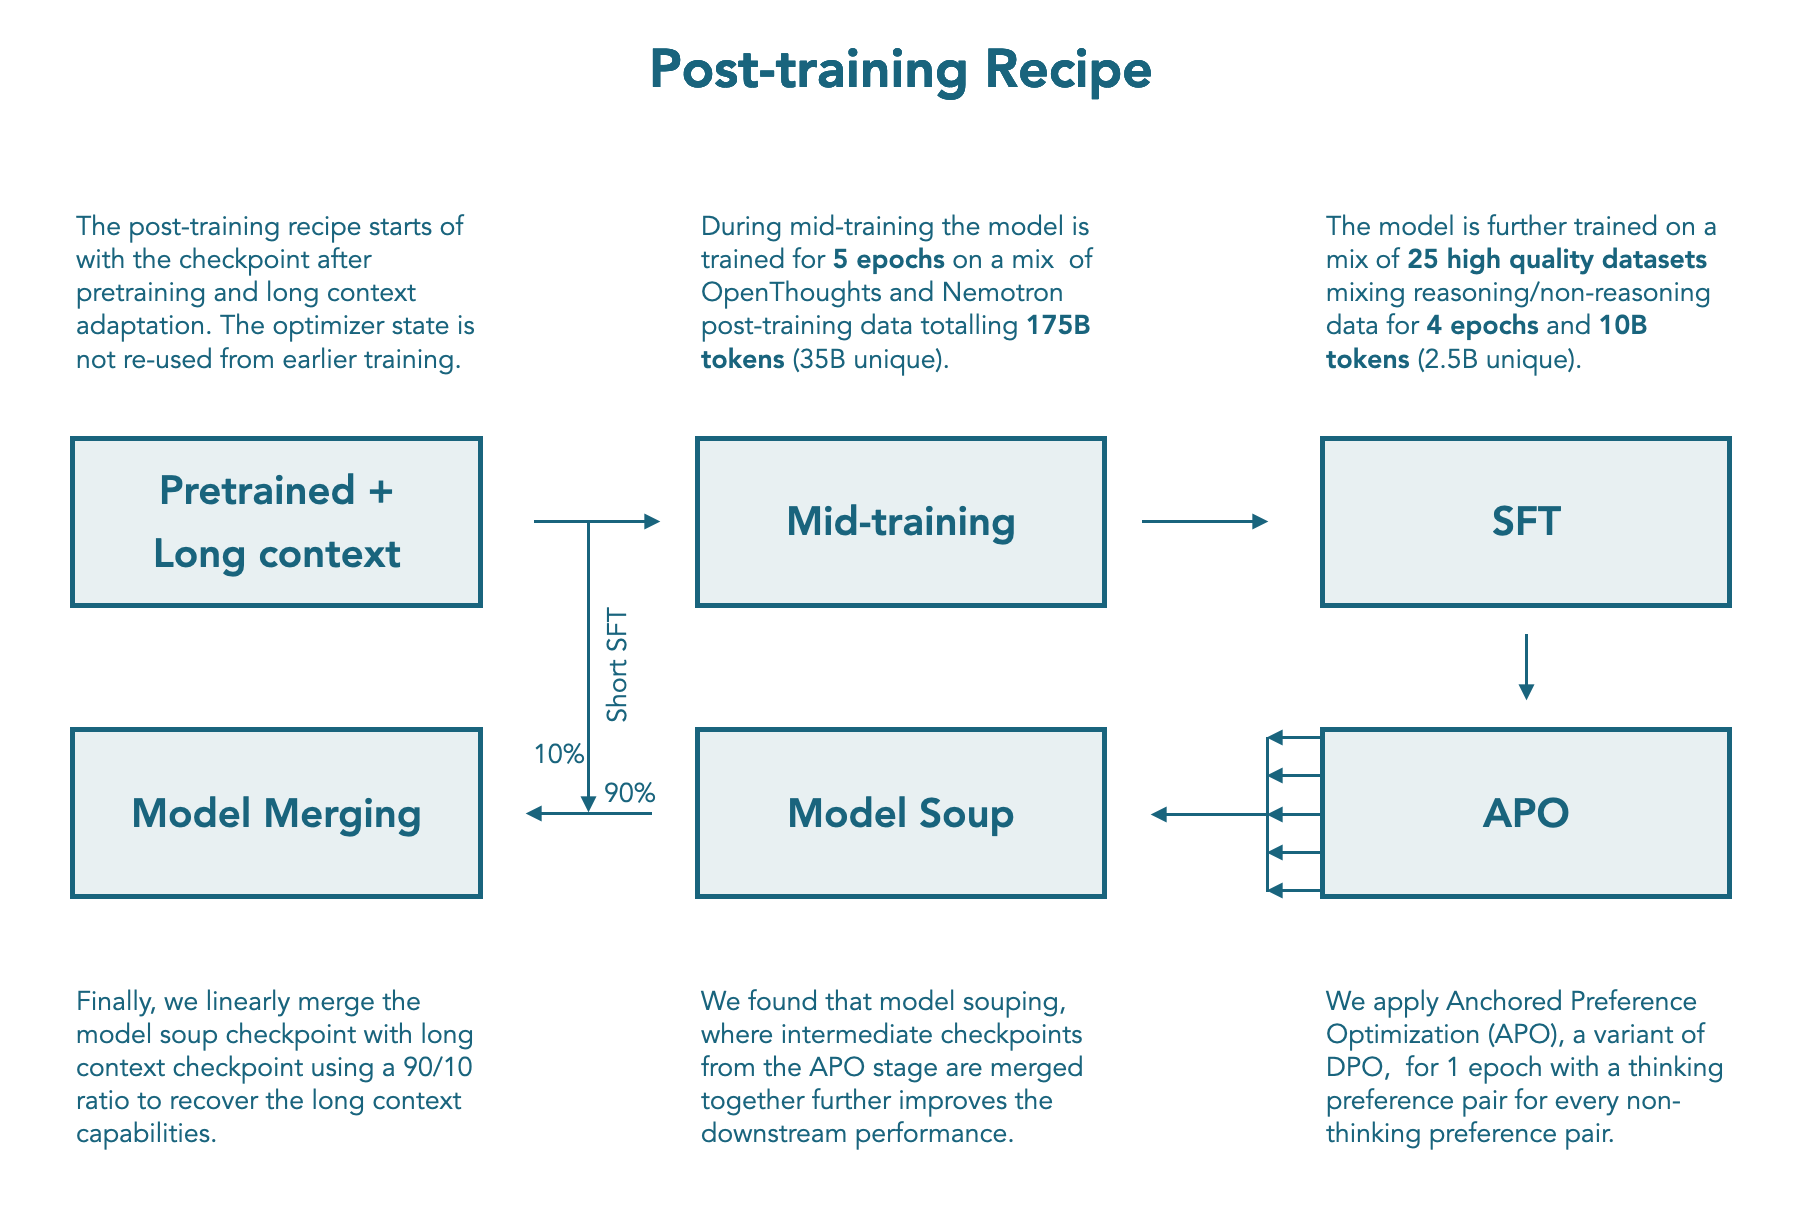

### SFT

In [ ]:
# Using the Chat Template that enables seamless switching between reasoning and non-reasoning modes
tokenizer_smollm3 = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM3-3B")

In [ ]:
%%capture
!pip install unsloth

Define the default arguments to match SmolLM3 training configurations or compensate for limited compute power.

In [ ]:
default_args = {
    "model_id": "HuggingFaceTB/SmolLM3-3B-Base",
    "streaming": False,
    "dataset_text_field": "text",
    "max_seq_length": 2048,
    "max_steps": 80,
    "micro_batch_size": 1, # original value (3) not used for computational reasons
    "gradient_accumulation_steps": 4, # accumulates 4 mini batches before updating the model's weights; original value (1) not used fto speed up training
    "weight_decay": 0.1,
    "bf16": False,

    "use_bnb": False,
    "attention_dropout": 0.1,
    "learning_rate": 3e-4,
    "lr_scheduler_type": "cosine",
    "warmup_steps": 10,
    "seed": 42,
    "output_dir": "sft_smollm3",
    "num_proc": None,

    "evaluation_strategy": "steps",
    "eval_steps": 20,

}

We only stream 750 examples from the whole dataset to keep it compute friendly. We also an instruction dataset since we use tthe Base model for finetuning, and this model was only pretrained, so it would have troubles following any instructions without proper finetuning.

In [ ]:
# Supervised Finetuning
# ds = load_dataset("HuggingFaceTB/smoltalk2", "SFT", split="Mixture_of_Thoughts_science_no_think")
get_dataset_split_names("HuggingFaceTB/smoltalk2", "SFT")

Finetune the base model on 'no-think' and 'think' datasets

In [ ]:
no_think_stream = load_dataset("HuggingFaceTB/smoltalk2", "SFT", split="smoltalk_smollm3_everyday_conversations_no_think", streaming=True)
no_think_iterable_ds = no_think_stream.take(750)
no_think_dicts = list(no_think_iterable_ds)
no_think_ds = Dataset.from_list(no_think_dicts)


think_stream = load_dataset("HuggingFaceTB/smoltalk2", "SFT", split="smoltalk_everyday_convs_reasoning_Qwen3_32B_think", streaming=True)
think_iterable_ds = think_stream.take(750)
think_dicts = list(think_iterable_ds)
think_ds = Dataset.from_list(think_dicts)

sft_ds = concatenate_datasets([no_think_ds, think_ds])
sft_ds

In [ ]:
sft_ds[0]

In [ ]:
instruct_stream = load_dataset("HuggingFaceTB/everyday-conversations-llama3.1-2k", split="train_sft", streaming=True)

instruct_iterable_ds = instruct_stream.take(3000)

instruct_dicts = list(instruct_iterable_ds)

instruct_ds = Dataset.from_list(instruct_dicts)
instruct_ds

In [ ]:
instruct_ds = instruct_ds.remove_columns(['topic', 'subtopic', 'subsubtopic', 'full_topic', 'token_length'])
instruct_ds

In [ ]:
instruct_ds[0]

We apply the chat template the model is expecting to receive. Thankfully, it can be simple using Unsloth chat template. What the the "chatml" chat will do is adding `<im_start>` and `<im_end> ` statements, so the model knows where the user and assistant messages start and end.

In [ ]:
# Configuring the datasets for Finetuning
tokenizer = get_chat_template(
    tokenizer_smollm3,
    chat_template = "chatml",
)

def tailor_to_finetune(rows):
   conversations = rows["messages"]
   texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in conversations]
   return { "text" : texts, }

# Apply the formatting function to your dataset using the map method
instruct_ds = instruct_ds.map(tailor_to_finetune, batched = True)
sft_ds = sft_ds.map(tailor_to_finetune, batched = True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM3-3B-Base")
# tokenizer.chat_template = finetuned_chat_template
dtype=None
load_in_4bit = True
model_smol, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "HuggingFaceTB/SmolLM3-3B-Base",
    max_seq_length = default_args['max_seq_length'],
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
# model = AutoModel.from_pretrained("unsloth/SmolLM3-3B-128K-GGUF", dtype="auto").to(device)

We split the dataset into train and test (which will be used for validation) sets.

In [ ]:
instruct_ds = instruct_ds.train_test_split(test_size=0.2)
train_instruct_ds = instruct_ds['train']
test_instruct_ds = instruct_ds['test']

sft_ds = sft_ds.train_test_split(test_size=0.2)
train_sft_ds = sft_ds['train']
test_sft_ds = sft_ds['test']

Here we set up logging to see training and validation loss changes.

In [ ]:
wandb.login()

In [ ]:
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="abanfalvi-org",
    # Set the wandb project where this run will be logged.
    project="sft_smollm3",
)

In [ ]:
def SFT_training(args, sft_ds, test_sft_ds):

  # LoRA
  model = FastLanguageModel.get_peft_model(
      model_smol,
      r=16,
      lora_alpha=16,
      target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
      lora_dropout=0.1,
      bias="none",
      use_gradient_checkpointing = True,
  )

  # set up trainer
  sft_args=SFTConfig(
      dataset_text_field=args['dataset_text_field'],
      dataset_num_proc=args['num_proc'],
      eval_strategy=args['evaluation_strategy'],
      eval_steps=args['eval_steps'],
      max_length=args['max_seq_length'],
      per_device_train_batch_size=args['micro_batch_size'],
      gradient_accumulation_steps=args['gradient_accumulation_steps'],
      warmup_steps=args['warmup_steps'],
      max_steps=args['max_steps'],
      learning_rate=args['learning_rate'],
      lr_scheduler_type=args['lr_scheduler_type'],
      weight_decay=args['weight_decay'],
      bf16=args['bf16'],
      logging_strategy="steps",
      logging_steps=5,
      output_dir=args['output_dir'],
      optim="paged_adamw_8bit",
      seed=args['seed'],
      run_name=f"train-{args['model_id'].split('/')[-1]}",
      report_to="wandb",
      packing=True,
      metric_for_best_model="loss",
      load_best_model_at_end=True
  )

  trainer = SFTTrainer(
      model=model,
      processing_class=tokenizer_smollm3,
      train_dataset=sft_ds,
      eval_dataset=test_sft_ds,
      args=sft_args,
  )

  trainer.add_callback(
    EarlyStoppingCallback(
        early_stopping_patience=3,
        early_stopping_threshold=0.001
      )
  )

  trainer.train()

The model is training, however, it overfits after the second epoch, which is understandable due to the small size of the dataset.

In [ ]:
# First we only train the model on the subset of the dataset to make sure things are working well
subset_sft = train_sft_ds.select(range(100))
subset_instr_train = train_instruct_ds.select(range(100))
subset_instr_test = test_instruct_ds.select(range(50))
SFT_training(default_args, subset_instr_train, subset_instr_test)

Shuffle the training dataset so the 'think' and 'no think' datasets are mixed.

In [ ]:
train_instruct_ds.shuffle()
train_sft_ds.shuffle()

Train the model on the Instruction dataset first.

In [ ]:
SFT_training(default_args, train_instruct_ds, test_instruct_ds)

Inference Time!

In [ ]:
messages = [
    {
    "role": "user",
    "content": "I need to find a exclusive African dishes for my next date, but open to Asian ones if you can convince me, needs some tips!",
    },
            ]
inputs = tokenizer_smollm3.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
    tokenize = True,
    return_dict = True,
).to("cuda")

_ = model_smol.generate(
    **inputs,
    max_new_tokens = 512,
    # SmolLM3 recommended
    temperature = 0.6, top_p = 0.95,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

Looks fine as far! Now we can save the LoRA adapters of the model that were finetuned.

In [ ]:
# Save the LoRA adapters
model_smol.save_pretrained("instr_smollm3")
tokenizer.save_pretrained("instr_smollm3")

Now, let us train it on the reasoning dataset.

In [ ]:
SFT_training(default_args, train_sft_ds, test_sft_ds)

In [ ]:
# Inference: try out again the new finetuned model
messages = [{
    "role": "user",
    "content": "I want to take up an adventurous sport that is also very dangerous at the same time. I am a beginner to this, so I do not want to start with the most extreme one. Suggest me a couple that I should or might wanna try",
}]
inputs = tokenizer_smollm3.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
    tokenize = True,
    return_dict = True,
).to("cuda")

from transformers import TextStreamer
_ = model_smol.generate(
    **inputs,
    max_new_tokens = 1024,
    # SmolLM3 recommended
    temperature = 0.6, top_p = 0.95,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

Save the model

In [ ]:
# Save the LoRA adapters
model_smol.save_pretrained("sft_smollm3")
tokenizer.save_pretrained("sft_smollm3")

### [APO](https://arxiv.org/pdf/2408.06266)

In [ ]:
pip install -U bitsandbytes>=0.46.1

First we set up the model to train, we use QLoRA to stay within the limit of the computational resources. We use SmolLM2 as it was properly, and for a longer time, finetuned on instruction dataset.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import torch.nn.functional as F

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

model_smollm2 = AutoModelForCausalLM.from_pretrained(
    "HuggingFaceTB/SmolLM2-1.7B-Instruct",
    quantization_config=quantization_config,
    dtype=torch.bfloat16
)
tokenizer_smollm2_apo = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B-Instruct")

# Resize model embeddings to match tokenizer vocab size if necessary
if model_smollm2.config.vocab_size < len(tokenizer_smollm2_apo):
    model_smollm2.resize_token_embeddings(len(tokenizer_smollm2_apo))

policy_model = model_smollm2
reference_model = model_smollm2

In [ ]:
# Set up LoRA
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.1,
)

policy_model = get_peft_model(policy_model, config)
reference_model = get_peft_model(reference_model, config)

In [ ]:
policy_model.print_trainable_parameters()

Let us load the dataset that we are going to use, which is going to be the same as they originally used for model training.

In [ ]:
# Preparing the dataset for APO
get_dataset_split_names("HuggingFaceTB/smoltalk2", "Preference")

In [ ]:
no_think_stream = load_dataset("HuggingFaceTB/smoltalk2", "Preference", split="llama_3.1_tulu_3_8b_preference_mixture_no_think", streaming=True)
no_think_iterable_ds = no_think_stream.take(1200)
no_think_dicts = list(no_think_iterable_ds)
no_think_ds = Dataset.from_list(no_think_dicts)


think_stream = load_dataset("HuggingFaceTB/smoltalk2", "Preference", split="tulu_3_8b_pref_mix_Qwen3_32B_Qwen3_0.6B_think", streaming=True)
think_iterable_ds = think_stream.take(1200)
think_dicts = list(think_iterable_ds)
think_ds = Dataset.from_list(think_dicts)

In [ ]:
no_think_ds[158]['chosen']

**Data Preprocessing**

Here we apply tokenization, truncation and padding to the dataset. For tokenization,

In [ ]:
def tokenize_and_truncate(row, tokenizer, max_seq_length=2048):
  messages = row['messages']
  if len(messages) == 0:
    raise ValueError("messages field is empty.")
  # tokenize the whole message where <assistant> is already added
  input_ids_result = tokenizer.apply_chat_template(
      conversation=messages,
      tokenize=True,
      return_tensors="pt",
      padding=False,
      truncation=True,
      max_length=max_seq_length,
      add_generation_prompt=False,
  )['input_ids']
  assert isinstance(input_ids_result, torch.Tensor)
  assert input_ids_result.ndim == 2, f"Expected 2D, but got {input_ids_result.ndim}"
  input_ids = input_ids_result
  labels = input_ids.clone()
  for message_idx, message in enumerate(messages):
    # first we check if it is a user message
    if message['role'] == 'user':
      # calculate the start index of this message
      if message_idx == 0:
          message_start_idx = 0
      else:
          # if it does not start at index 0, we tokenize the whole that is before this idx
          message_start_idx = tokenizer.apply_chat_template(
              conversation=messages[:message_idx],
              tokenize=True,
              return_tensors="pt",
              padding=False,
              truncation=True,
              max_length=max_seq_length,
              add_generation_prompt=False,
          )['input_ids'].shape[1] # returns the number of tokens that were tokenised
    if message_idx < len(messages) - 1 and messages[message_idx + 1]['role'] == 'assistant':
      # tokenise up to the assistant message type
      message_end_idx = tokenizer.apply_chat_template(
          conversation=messages[: message_idx + 1],
          tokenize=True,
          return_tensors="pt",
          padding=False,
          truncation=True,
          max_length=max_seq_length,
          add_generation_prompt=True, # add the <assistant> prefix token so it can be masked too
      )['input_ids'].shape[1]
    else:
      # if not user or assistant message type, tokenise up to it, but do not add any prefixes
      message_end_idx = tokenizer.apply_chat_template(
          conversation=messages[: message_idx + 1],
          tokenize=True,
          return_tensors="pt",
          padding=False,
          truncation=True,
          max_length=max_seq_length,
          add_generation_prompt=False,
      )['input_ids'].shape[1]

    # set the label to -100 for the non-assistant part
    labels[:, message_start_idx:message_end_idx] = -100
    if max_seq_length and message_end_idx >= max_seq_length:
        break

  attention_mask = torch.ones_like(input_ids)
  row['input_ids'] = input_ids.flatten()
  row['labels'] = labels.flatten()
  row['attention_mask'] = attention_mask.flatten()

  return row

Here we want to get the input_ids, labels and attention mask for the model

In [ ]:
def preference_tokenize_truncate(row, tokenizer, max_seq_length=2048, chosen_key = 'chosen', rejected_key = 'rejected'):
  chosen_messages = row[chosen_key]
  rejected_messages = row[rejected_key]

  if len(chosen_messages) == 0:
    raise ValueError("chosen messages field is empty.")
  if len(rejected_messages) == 0:
    raise ValueError("rejected messages field is empty.")

  chosen_encoded = tokenize_and_truncate({'messages': chosen_messages}, tokenizer, max_seq_length)
  rejected_encoded = tokenize_and_truncate({'messages': rejected_messages}, tokenizer, max_seq_length)

  return {
      'chosen_input_ids': chosen_encoded["input_ids"],
      'chosen_labels': chosen_encoded["labels"],
      'chosen_mask': chosen_encoded["attention_mask"],
      'rejected_input_ids': rejected_encoded["input_ids"],
      'rejected_labels': rejected_encoded["labels"],
      'rejected_mask': rejected_encoded["attention_mask"],
  }

no_think_ds_encoded = no_think_ds.map(preference_tokenize_truncate, remove_columns=['chat_template_kwargs', 'source'], fn_kwargs={'tokenizer': tokenizer_smollm2_apo})
think_ds_encoded = think_ds.map(preference_tokenize_truncate, remove_columns=['chat_template_kwargs', 'source'], fn_kwargs={'tokenizer': tokenizer_smollm2_apo})

pref_ds = concatenate_datasets([no_think_ds_encoded, think_ds_encoded])

In [ ]:
# Helper function to add padding to the input_ids, attention masks and labels
def pad_to_length(tensor: torch.Tensor, length: int, pad_value: int | float) -> torch.Tensor:
    """Right-pad a tensor to a specified length along the last dimension."""
    if tensor.size(-1) >= length:
        return tensor
    return F.pad(tensor, (0, length - tensor.size(-1)), value=pad_value)

In [ ]:
class PreferenceCollator:
  def __init__(self, pad_token_id: int):
    self.pad_token_id = pad_token_id

  def __call__(self, batch: list[dict[str, Any]]):
    max_chosen_length = -1
    max_rejected_length = -1

    # Calculate max length across all chosen and rejected sequences in the batch
    for item in batch:
      max_chosen_length = max(max_chosen_length, len(item['chosen_input_ids']))
      max_rejected_length = max(max_rejected_length, len(item['rejected_input_ids']))

    max_length = max(max_chosen_length, max_rejected_length)
    assert max_length > 0, 'dataset is empty'

    result = {}
    pad_values = {"labels": -100, "mask": 0, "input_ids": self.pad_token_id}

    # pad all 6 prefix-key type
    for prefix in ['chosen_', 'rejected_']:
      for key in ['input_ids', 'mask', 'labels']:
        full_key = f'{prefix}{key}'
        pad_value = pad_values[key]

        # Ensure items are tensors before padding and stack them
        padded_tensors = [
            pad_to_length(torch.tensor(item[full_key]), max_length, pad_value)
            for item in batch
        ]
        result[full_key] = torch.stack(padded_tensors)

    return result

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

pref_ds.with_format("torch")

pref_ds = pref_ds.train_test_split(test_size=0.2)
train_pref_ds = pref_ds['train']
val_pref_ds = pref_ds['test']

train_dataloader = DataLoader(train_pref_ds, batch_size=16, collate_fn=PreferenceCollator(tokenizer_smollm2_apo.pad_token_id), shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_pref_ds, batch_size=16, collate_fn=PreferenceCollator(tokenizer_smollm2_apo.pad_token_id), shuffle=False, drop_last=False)

In [ ]:
# example to look at the Dataloader object to see if it was initialised properly
for batch in train_dataloader:
    break

print("batch.keys:", batch.keys())

Set up the APO loss function

In [ ]:
def compute_apo_loss(
    model_chosen_logprobs,
    model_rejected_logprobs,
    reference_chosen_logprobs,
    reference_rejected_logprobs,
    beta=0.1):

  model_logaratios = model_chosen_logprobs - model_rejected_logprobs
  reference_logaratios = reference_chosen_logprobs - reference_rejected_logprobs

  chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
  rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()

  losses = -F.sigmoid(beta * model_logaratios) + F.sigmoid(beta * reference_logaratios)

  return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

In [ ]:
def compute_logprobs(logits, labels, selection_mask=None):
  # here we ensure that the model predicts the next token while it cannot attend to the ground truth token
  labels = labels[:, 1:].clone() # batch_size, num_tokens
  logits = logits[:, :-1, :] # batch_size, num_tokens, vocabs_size
  log_prob = F.log_softmax(logits, dim=-1)
  selected_log_probs = torch.gather(
      input=log_prob,
      dim=-1,
      index=labels.unsqueeze(-1) # to make the labels to have the same dim as log_probs
  ).squeeze(-1)
  if selection_mask is not None:
    mask = selection_mask[:, 1:].clone()
    # we set the log probs of padding tokens to zero, so the model is only penalized on its prediction on real data
    selected_log_probs = selected_log_probs * mask
    avg_log_prob = selected_log_probs.mean(-1) / mask.mean(-1)
    return avg_log_prob
  else:
    return selected_log_probs.mean(-1)

Calculates the log probabilities for the chosen and rejected answers

In [ ]:
def compute_apo_loss_batch(batch, policy_model, reference_model, beta):
  policy_chosen_log_probas = compute_logprobs(
      logits=policy_model(batch['chosen_input_ids']),
      labels=batch['chosen_labels'],
      selection_mask=batch['chosen_mask']
  )
  policy_rejected_log_probas = compute_logprobs(
      logits=policy_model(batch['rejected_input_ids']),
      labels=batch['rejected_labels'],
      selection_mask=batch['rejected_mask']
  )

  with torch.no_grad():
    ref_chosen_log_probas = compute_logprobs(
      logits=reference_model(batch['chosen_input_ids']),
      labels=batch['chosen_labels'],
      selection_mask=batch['chosen_mask']
  )
    ref_rejected_log_probas = compute_logprobs(
      logits=reference_model(batch['rejected_input_ids']),
      labels=batch['rejected_labels'],
      selection_mask=batch['rejected_mask']
  )
  loss, chosen_rewards, rejected_rewards = compute_apo_loss(
      policy_chosen_log_probas,
      policy_rejected_log_probas,
      ref_chosen_log_probas,
      ref_rejected_log_probas
  )
  return loss, chosen_rewards, rejected_rewards

In [ ]:
# the purpose of this function is to calculate the loss for the batches of the dataloader, then takes the average result
def compute_apo_loss_loader(data_loader, policy_model, reference_model, beta, num_batches=None):
  total_loss, total_chosen_rewards, total_rejected_rewards = 0., 0., 0.
  if len(data_loader) == 0:
    return float('nan')
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, batch in enumerate(data_loader):
    if i < num_batches:
      loss, chosen_rewards, rejected_rewards = compute_apo_loss_batch(batch, policy_model, reference_model, beta)
      total_loss += loss
      total_chosen_rewards += chosen_rewards.item()
      total_rejected_rewards += rejected_rewards.item()
    else:
      break

  total_loss /= num_batches
  total_chosen_rewards /= num_batches
  total_rejected_rewards /= num_batches
  return total_loss, total_chosen_rewards, total_rejected_rewards

In [ ]:
# the aim is to get the eval loss of the model
def evaluate_apo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):
  policy_model.eval()
  with torch.no_grad():
    train_loss, train_chosen_rewards, train_rejected_rewards = compute_apo_loss_loader(train_loader, policy_model, reference_model, beta, num_batches=eval_iter)
    val_loss, val_chosen_rewards, val_rejected_rewards = compute_apo_loss_loader(val_loader, policy_model, reference_model, beta, num_batches=eval_iter)

  res = {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen_rewards,
        "train_rejected_reward": train_rejected_rewards,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen_rewards,
        "val_rejected_reward": val_rejected_rewards
    }

  policy_model.train()
  return res

Training the model

In [ ]:
def train_model_apo(
    policy_model, reference_model, train_loader, val_loader,
    optimizer, num_epochs, beta,
    eval_freq, eval_iter, tokenizer
):
  tracking = {
      "train_losses": [],
      "train_chosen_rewards": [],
      "train_rejected_rewards": [],
      "val_losses": [],
      "val_chosen_rewards": [],
      "val_rejected_rewards": [],
      "tokens_seen": []
  }
  tokens_seen, global_step = 0, -1

  # Move policy_model to device
  policy_model.to(device)
  reference_model.to(device)

  for epoch in range(num_epochs):
    policy_model.train()
    for batch in train_loader:
      # Move batch data to device
      batch = {k: v.to(device) for k, v in batch.items()}

      optimizer.zero_grad()
      loss, chosen_rewards, rejected_rewards = compute_apo_loss_batch(
          batch=batch,
          policy_model=policy_model,
          reference_model=reference_model,
          beta=beta
      )
      loss.backward()
      optimizer.step()

      tokens_seen += batch['chosen_input_ids'].numel()
      global_step += 1


      # Evaluation step
      if global_step % eval_freq == 0:
          res = evaluate_apo_loss_loader(
              policy_model=policy_model,
              reference_model=reference_model,
              train_loader=train_loader,
              val_loader=val_loader,
              beta=beta,
              eval_iter=eval_iter
          )
          tracking["train_losses"].append(res["train_loss"])
          tracking["train_chosen_rewards"].append(res["train_chosen_reward"])
          tracking["train_rejected_rewards"].append(res["train_rejected_reward"])
          tracking["val_losses"].append(res["val_loss"])
          tracking["val_chosen_rewards"].append(res["val_chosen_reward"])
          tracking["val_rejected_rewards"].append(res["val_rejected_reward"])
          tracking["tokens_seen"].append(tokens_seen)
          train_reward_margin = res["train_chosen_reward"] - res["train_rejected_reward"]
          val_reward_margin = res["val_chosen_reward"] - res["val_rejected_reward"]

          print(
              f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {res['train_loss']:.3f}, Val loss {res['val_loss']:.3f}, "
              f"Train reward margins {train_reward_margin:.3f}, "
              f"Val reward margins {val_reward_margin:.3f}"
          )

  return tracking

In [ ]:
torch.manual_seed(123)

res = evaluate_apo_loss_loader(
    policy_model=policy_model, # model we want to optimize
    reference_model=reference_model, # the original model we keep unchanged (same as the policy model)
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    beta=0.1,
    eval_iter=5
)

print("Training loss:", res["train_loss"])
print("Validation loss:", res["val_loss"])

print("Train reward margin:", res["train_chosen_reward"] - res["train_rejected_reward"])
print("Val reward margin:", res["val_chosen_reward"] - res["val_rejected_reward"])

In [ ]:
start_time = time.time()

torch.manual_seed(123)


optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

num_epochs = 1
tracking = train_model_apo(
    policy_model=policy_model, # model we want to optimize
    reference_model=reference_model, # the original model we keep unchanged (same as the policy model)
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.1,
    eval_freq=5,
    eval_iter=5,
    tokenizer=tokenizer_smollm2_apo
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")